In [1]:
# Importar librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [40]:
df = pd.read_csv('data/airline_passengers.csv', index_col='Month', parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
# Creación del objeto ses
ses = SimpleExpSmoothing(df['Passengers'])

/home/jair/anaconda3/envs/series/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [4]:
df.index
# No se inicializa una frecuencia, por lo que se establece despues como mensual

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [5]:
df.index.freq = 'MS'

In [6]:
ses = SimpleExpSmoothing(df['Passengers'], initialization_method='legacy-heuristic')

In [7]:
# Obtener resulatos con hiperparametro de suavizado establecido manualmente
# alpha = 0.1
res_01 = ses.fit(smoothing_level = 0.1, optimized = False)

In [8]:
res_01

In [9]:
# Observar predicciones (todos los datos dentro del entrenamiento)
res_01.predict(start = df.index[0], end = df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    112.600000
1949-04-01    114.540000
1949-05-01    115.986000
                 ...    
1960-08-01    453.638355
1960-09-01    468.874520
1960-10-01    472.787068
1960-11-01    471.608361
1960-12-01    463.447525
Freq: MS, Length: 144, dtype: float64

In [10]:
df['SES_01'] = res_01.predict(start = df.index[0], end = df.index[-1])
df.head()

,Passengers,SES_01
Month,,
1949-01-01,112,112.000
1949-02-01,118,112.000
1949-03-01,132,112.600
1949-04-01,129,114.540
1949-05-01,121,115.986


In [11]:
res_01.fittedvalues

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    112.600000
1949-04-01    114.540000
1949-05-01    115.986000
                 ...    
1960-08-01    453.638355
1960-09-01    468.874520
1960-10-01    472.787068
1960-11-01    471.608361
1960-12-01    463.447525
Freq: MS, Length: 144, dtype: float64

In [12]:
type(res_01.fittedvalues)

pandas.core.series.Series

In [13]:
np.allclose(df['Passengers'], res_01.fittedvalues)

False

In [14]:
alpha = 0.9
res_02 = ses.fit(smoothing_level = alpha, optimized = False)

In [15]:
df['SES_09'] = res_02.predict(start = df.index[0], end = df.index[-1])

In [16]:
res_02

<Axes: xlabel='Month'>

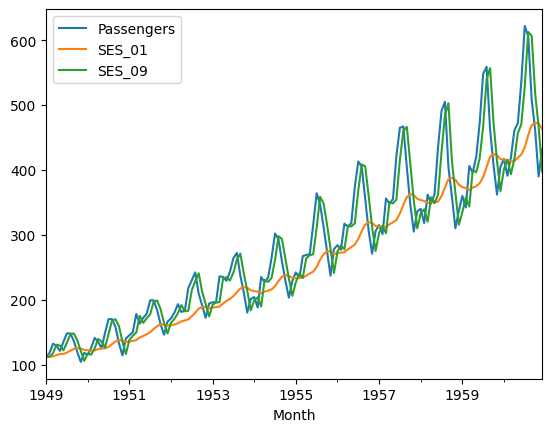

In [17]:
df.plot()

#### Ahora tratarlo como si fuera ML con un conjunto de entrenamiento y otro de pruebas

In [22]:
# Establezco una parte del df principal para que una parte sea de entrenamiento y otra de pruebas
n_test = 12
train = df.iloc[:-n_test]
test = df.iloc[-n_test:]

In [23]:
# Creación de un nuevo objeto
ses = SimpleExpSmoothing(train['Passengers'], initialization_method='legacy-heuristic')

In [ ]:
# Entrenamineto automatico para obtener el mejor coeficiente de suavizado
res = ses.fit()

In [25]:
# Establecer un vector booleano en el que se establece cuales indices del df son de entrenamiento y cuales de pruebas
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]
type(train_idx)

numpy.ndarray

In [26]:
res.fittedvalues

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    117.970000
1949-04-01    131.929850
1949-05-01    129.014649
                 ...    
1959-08-01    547.618697
1959-09-01    558.943093
1959-10-01    463.479715
1959-11-01    407.282399
1959-12-01    362.226412
Freq: MS, Length: 132, dtype: float64

In [27]:
res.forecast(12)

1960-01-01    404.786132
1960-02-01    404.786132
1960-03-01    404.786132
1960-04-01    404.786132
1960-05-01    404.786132
1960-06-01    404.786132
1960-07-01    404.786132
1960-08-01    404.786132
1960-09-01    404.786132
1960-10-01    404.786132
1960-11-01    404.786132
1960-12-01    404.786132
Freq: MS, dtype: float64

<Axes: xlabel='Month'>

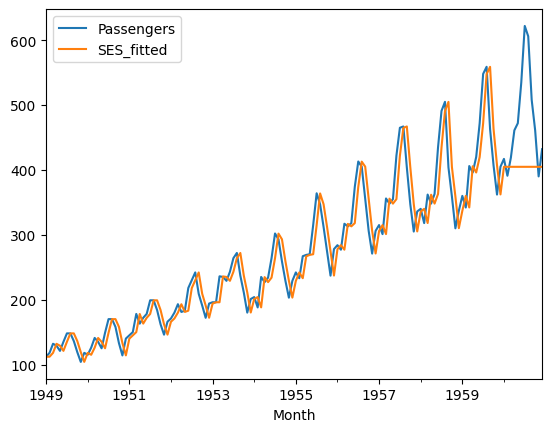

In [ ]:
# Crear una columna en el df original, estableciendo con que indices y asignar el resultado de prediccion interna y forecasting
df.loc[train_idx, 'SES_fitted'] = res.fittedvalues
df.loc[test_idx, 'SES_fitted'] = res.forecast(n_test)

df[['Passengers', 'SES_fitted']].plot()

In [ ]:
print(f"Coeficiente de suavizado alfa: {res.params['smoothing_level']}")
# Se puede ver que la mejor opcion es que influya más un valor mas reciente en la serie

Coeficiente de suavizado alfa: 0.995
